# Poverty Prediction from Satellite Images using CNNs
This notebook explores convolutional neural networks (CNNs) to predict poverty levels using satellite images. We use ResNet and EfficientNet architectures and compare their performance using k-fold cross-validation.


**Author:** Gabriela Penaherrera  
**Date:** July 2025  


In [1]:
# STEP 1: Unzip the .zip file with all image folders
import zipfile

zip_path = "poverty_images.zip"
output_dir = "images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)


In [2]:
# STEP 2: Build a DataFrame with all valid .npz image files
from pathlib import Path
import pandas as pd

# Get all .npz files recursively from the extracted folder
root_dir = Path("images/lsms")
all_files = list(root_dir.rglob("*.npz"))

# Create a DataFrame with image metadata
data = []
for file in all_files:
    lsms_id = file.stem
    subfolder = file.parent.name
    full_path_absolute = str(file.resolve())
    data.append({
        'lsms_id': lsms_id,
        'subfolder': subfolder,
        'image_name': file.name,
        'full_path_absolute': full_path_absolute
    })

df_real = pd.DataFrame(data)


In [3]:
# STEP 3: Load the labels and merge with image paths
df_labels = pd.read_csv("lsms_asset_indices.csv")
df = df_real.merge(df_labels[['lsms_id', 'asset_index']], on='lsms_id', how='inner')
print(f"Total labeled images: {len(df)}")


Total labeled images: 2763


In [4]:
# STEP 4: Normalize the asset index (mean 0, std 1)
mean_asset = df['asset_index'].mean()
std_asset = df['asset_index'].std()
df['asset_index_norm'] = (df['asset_index'] - mean_asset) / std_asset

print(f"Mean: {mean_asset:.4f}, Std: {std_asset:.4f}")


Mean: -0.0361, Std: 1.4942


In [5]:
# Step 5: Custom Dataset class for loading .npz files
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
from PIL import Image

class LSMSDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['full_path_absolute']
        label = row['asset_index_norm']

        try:
            with np.load(path) as data:
                img_array = data['x']

            img_array = np.stack([
                img_array[3],  # NIR
                img_array[2],  # Red
                img_array[1]   # Green
            ], axis=-1)

            img_array = cv2.resize(img_array, (100, 100))
            img = Image.fromarray((img_array * 255).astype(np.uint8))

            if self.transform:
                img = self.transform(img)

            return img, torch.tensor(label, dtype=torch.float32)

        except Exception as e:
            print(f"Error loading {path}: {e}")


In [6]:
# # STEP 6: Set up image preprocessing and augmentation (flip, rotate, normalize)
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [7]:
# STEP 7: Build a custom CNN model for regression using a pretrained backbone
from torchvision.models import resnet18, resnet50, efficientnet_b0
from torchvision.models import ResNet18_Weights, ResNet50_Weights, EfficientNet_B0_Weights
import torch.nn as nn


def build_model(model_name="resnet18"):
    if model_name == "resnet18":
        base = resnet18(weights=ResNet18_Weights.DEFAULT)
        in_features = base.fc.in_features
        base.fc = nn.Identity()

    elif model_name == "resnet50":
        base = resnet50(weights=ResNet50_Weights.DEFAULT)
        in_features = base.fc.in_features
        base.fc = nn.Identity()

    elif model_name == "efficientnet_b0":
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        in_features = base.classifier[1].in_features
        base.classifier = nn.Identity()

    else:
        raise ValueError(f"Model not recognized: {model_name}")

    model = nn.Sequential(
        base,
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, 1)
    )

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.SmoothL1Loss()


In [8]:
# STEP 8: Define the evaluation function
from sklearn.metrics import mean_absolute_error, r2_score

def evaluate(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            outputs = model(images)
            preds.extend(outputs.cpu().numpy())
            trues.extend(labels.cpu().numpy())
    preds_np = np.array(preds)
    trues_np = np.array(trues)
    loss = criterion(torch.tensor(preds_np), torch.tensor(trues_np)).item()
    mae = mean_absolute_error(trues_np, preds_np)
    r2 = r2_score(trues_np, preds_np)
    return loss, mae, r2, preds_np, trues_np


In [9]:
# STEP 9: Train the model and evaluate performance using validation and test sets
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, test_loader, model_name):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_val_loss = float('inf')
    patience = 6
    trigger_times = 0

    for epoch in range(50):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader.dataset)

        scheduler.step(val_loss)
        print(f"{model_name} | Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), f"best_model_{model_name}.pth")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(f"best_model_{model_name}.pth"))
    val_metrics = evaluate(model, val_loader)
    test_metrics = evaluate(model, test_loader)

    # Plot predictions vs actuals
    plt.scatter(val_metrics[4], val_metrics[3], alpha=0.6)
    plt.title(f"Validation Predictions vs Actuals: {model_name}")
    plt.xlabel("True Asset Index")
    plt.ylabel("Predicted Asset Index")
    plt.grid(True)
    plt.show()

    return val_metrics[:3], test_metrics[:3]  # Only return loss, mae, r2


In [10]:
# STEP 10: Train and evaluate all models (ResNet18, ResNet50, EfficientNetB0) and compare results

def run_all_models(df, model_names=["resnet18", "resnet50", "efficientnet_b0"]):
    dataset = LSMSDataset(df, transform=transform)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    results = {}
    for model_name in model_names:
        print(f"\n=== Training {model_name} ===")
        model = build_model(model_name).to(device)
        val_metrics, test_metrics = train_model(model, train_loader, val_loader, test_loader, model_name)
        results[model_name] = {
            "val_loss": val_metrics[0], "val_mae": val_metrics[1], "val_r2": val_metrics[2],
            "test_loss": test_metrics[0], "test_mae": test_metrics[1], "test_r2": test_metrics[2]
        }

    df_results = pd.DataFrame(results).T.sort_values("val_loss")
    print("\nFinal Model Comparison:")
    print(df_results)
    return df_results



=== Training resnet18 ===


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.9MB/s]


resnet18 | Epoch 1, Train Loss: 0.3413, Val Loss: 0.4119
resnet18 | Epoch 2, Train Loss: 0.2733, Val Loss: 0.2648
resnet18 | Epoch 3, Train Loss: 0.2380, Val Loss: 0.5365
resnet18 | Epoch 4, Train Loss: 0.2244, Val Loss: 0.4429
resnet18 | Epoch 5, Train Loss: 0.2074, Val Loss: 0.2526
resnet18 | Epoch 6, Train Loss: 0.2064, Val Loss: 0.3716
resnet18 | Epoch 7, Train Loss: 0.1830, Val Loss: 0.6302
resnet18 | Epoch 8, Train Loss: 0.1820, Val Loss: 0.2007
resnet18 | Epoch 9, Train Loss: 0.1742, Val Loss: 0.2165
resnet18 | Epoch 10, Train Loss: 0.1729, Val Loss: 0.3927
resnet18 | Epoch 11, Train Loss: 0.1858, Val Loss: 0.2158
resnet18 | Epoch 12, Train Loss: 0.1419, Val Loss: 0.2253
resnet18 | Epoch 13, Train Loss: 0.1359, Val Loss: 0.2160
resnet18 | Epoch 14, Train Loss: 0.1277, Val Loss: 0.1904
resnet18 | Epoch 15, Train Loss: 0.1255, Val Loss: 0.1858
resnet18 | Epoch 16, Train Loss: 0.1182, Val Loss: 0.2540
resnet18 | Epoch 17, Train Loss: 0.1102, Val Loss: 0.2303
resnet18 | Epoch 18, Tr

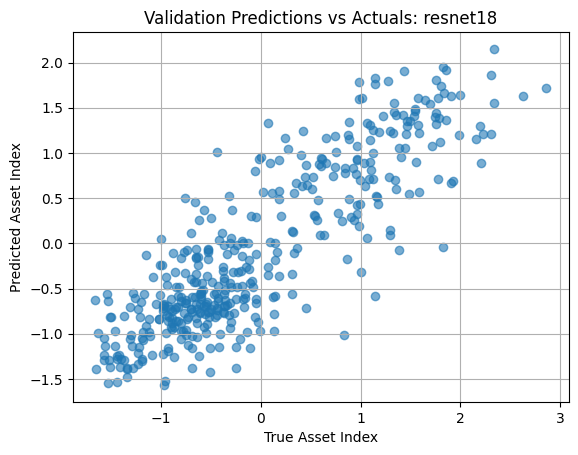


=== Training resnet50 ===


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]


resnet50 | Epoch 1, Train Loss: 0.3264, Val Loss: 0.3996
resnet50 | Epoch 2, Train Loss: 0.2203, Val Loss: 0.2589
resnet50 | Epoch 3, Train Loss: 0.1968, Val Loss: 0.2873
resnet50 | Epoch 4, Train Loss: 0.1788, Val Loss: 0.3197
resnet50 | Epoch 5, Train Loss: 0.1738, Val Loss: 0.3955
resnet50 | Epoch 6, Train Loss: 0.1442, Val Loss: 0.2052
resnet50 | Epoch 7, Train Loss: 0.1175, Val Loss: 0.1775
resnet50 | Epoch 8, Train Loss: 0.1107, Val Loss: 0.1952
resnet50 | Epoch 9, Train Loss: 0.0995, Val Loss: 0.1966
resnet50 | Epoch 10, Train Loss: 0.0898, Val Loss: 0.1819
resnet50 | Epoch 11, Train Loss: 0.0799, Val Loss: 0.1413
resnet50 | Epoch 12, Train Loss: 0.0624, Val Loss: 0.1512
resnet50 | Epoch 13, Train Loss: 0.0572, Val Loss: 0.1510
resnet50 | Epoch 14, Train Loss: 0.0502, Val Loss: 0.1449
resnet50 | Epoch 15, Train Loss: 0.0450, Val Loss: 0.1499
resnet50 | Epoch 16, Train Loss: 0.0430, Val Loss: 0.1403
resnet50 | Epoch 17, Train Loss: 0.0401, Val Loss: 0.1392
resnet50 | Epoch 18, Tr

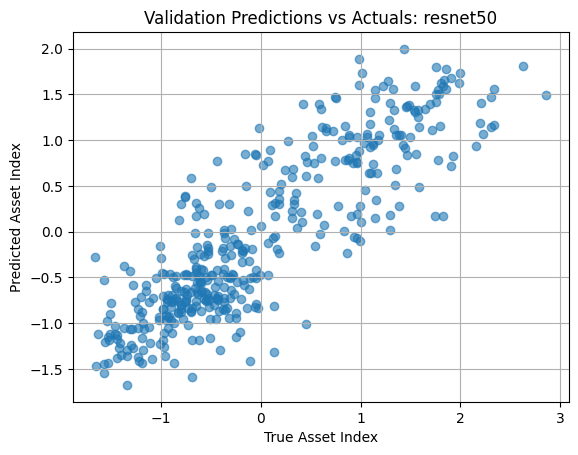


=== Training efficientnet_b0 ===


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 121MB/s] 


efficientnet_b0 | Epoch 1, Train Loss: 0.3275, Val Loss: 0.3665
efficientnet_b0 | Epoch 2, Train Loss: 0.2313, Val Loss: 0.2510
efficientnet_b0 | Epoch 3, Train Loss: 0.1905, Val Loss: 0.2093
efficientnet_b0 | Epoch 4, Train Loss: 0.1601, Val Loss: 0.2109
efficientnet_b0 | Epoch 5, Train Loss: 0.1463, Val Loss: 0.2059
efficientnet_b0 | Epoch 6, Train Loss: 0.1631, Val Loss: 0.1725
efficientnet_b0 | Epoch 7, Train Loss: 0.1310, Val Loss: 0.1798
efficientnet_b0 | Epoch 8, Train Loss: 0.1259, Val Loss: 0.1871
efficientnet_b0 | Epoch 9, Train Loss: 0.1116, Val Loss: 0.1622
efficientnet_b0 | Epoch 10, Train Loss: 0.1098, Val Loss: 0.1635
efficientnet_b0 | Epoch 11, Train Loss: 0.0882, Val Loss: 0.1579
efficientnet_b0 | Epoch 12, Train Loss: 0.0850, Val Loss: 0.1688
efficientnet_b0 | Epoch 13, Train Loss: 0.0787, Val Loss: 0.1623
efficientnet_b0 | Epoch 14, Train Loss: 0.0817, Val Loss: 0.1586
efficientnet_b0 | Epoch 15, Train Loss: 0.0621, Val Loss: 0.1434
efficientnet_b0 | Epoch 16, Train 

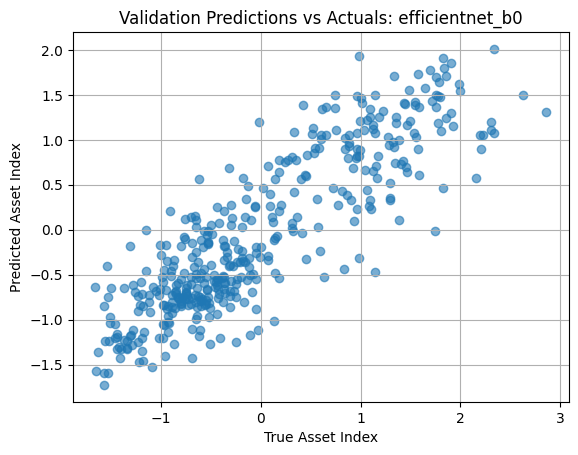


Final Model Comparison:
                 val_loss   val_mae    val_r2  test_loss  test_mae   test_r2
efficientnet_b0  0.124909  0.385667  0.749017   0.114012  0.363447  0.768251
resnet50         0.129136  0.387196  0.741693   0.113747  0.364061  0.771083
resnet18         0.132000  0.398991  0.733800   0.115579  0.367239  0.762755


In [11]:
results_df = run_all_models(df)

## Conclusion

All three models - ResNet18, ResNet50, and EfficientNetB0 - demonstrated very similar performance in predicting poverty from true color satellite images. While ResNet50 achieved the highest R² on the test set, EfficientNetB0 performed slightly better on the validation set, suggesting better generalization. The differences are minimal, so the choice of model may depend on practical considerations: ResNet18 is lighter and faster to train, while ResNet50 and EfficientNetB0 offer slightly higher accuracy.
